bacterial colony image classification project by " WISAM WAEEL SHAMOON "

In [1]:
!pip install timm # install PyTorch Image Models

     |████████████████████████████████| 376 kB 4.0 MB/s 


In [2]:
"""
# '    (* name of model to test in timm database)    '

all_densenet_models = timm.list_models('*resnet*')
all_densenet_models

"""

"\n# '    (* name of model to test in timm database)    '\n\nall_densenet_models = timm.list_models('*resnet*')\nall_densenet_models\n\n"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from torchvision import transforms as T,datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [5]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['Acinetobacter.baumanii', 'Actinomyces.israeli','Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens','Enterococcus.faecalis','Enterococcus.faecium','Escherichia.coli','Fusobacterium','Lactobacillus.casei','Lactobacillus.crispatus','Lactobacillus.delbrueckii','Lactobacillus.gasseri','Lactobacillus.jehnsenii','Lactobacillus.johnsonii','Lactobacillus.paracasei','Lactobacillus.plantarum','Lactobacillus.reuteri','Lactobacillus.rhamnosus','Lactobacillus.salivarius','Listeria.monocytogenes','Micrococcus.spp','Neisseria.gonorrhoeae','Porfyromonas.gingivalis','Propionibacterium.acnes','Proteus','Pseudomonas.aeruginosa','Staphylococcus.aureus','Staphylococcus.epidermidis','Staphylococcus.saprophiticus','Streptococcus.agalactiae','Veionella' ]
    
   
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [6]:
class CFG:

  epochs =25                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'resnet50'                 # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  #Data_DIR = "chest_xray"
  #TEST = "test"
  #TRAIN = "train"
  #VAL = "val"
  train_path='/content/drive/MyDrive/bacterial-colony-dataset/train'
  validate_path='/content/drive/MyDrive/bacterial-colony-dataset/vald'
  test_path='/content/drive/MyDrive/bacterial-colony-dataset/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [7]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])


In [8]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

testset=datasets.ImageFolder(CFG.test_path,transform=validate_transform)
print("testset Size:  {}".format(len(testset)))

Trainset Size:  2724
validateset Size:  681
testset Size:  66


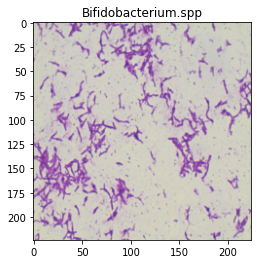

In [9]:
img,label = trainset[322]
#print(trainset.class_to_idx)

class_name = ['Acinetobacter.baumanii', 'Actinomyces.israeli','Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens','Enterococcus.faecalis','Enterococcus.faecium','Escherichia.coli','Fusobacterium','Lactobacillus.casei','Lactobacillus.crispatus','Lactobacillus.delbrueckii','Lactobacillus.gasseri','Lactobacillus.jehnsenii','Lactobacillus.johnsonii','Lactobacillus.paracasei','Lactobacillus.plantarum','Lactobacillus.reuteri','Lactobacillus.rhamnosus','Lactobacillus.salivarius','Listeria.monocytogenes','Micrococcus.spp','Neisseria.gonorrhoeae','Porfyromonas.gingivalis','Propionibacterium.acnes','Proteus','Pseudomonas.aeruginosa','Staphylococcus.aureus','Staphylococcus.epidermidis','Staphylococcus.saprophiticus','Streptococcus.agalactiae','Veionella' ]
show_image(img,class_name[label])

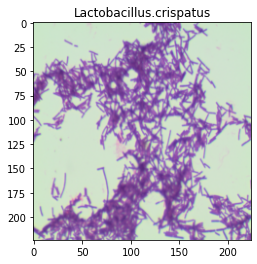

In [10]:
img,label = testset[22]
#print(trainset.class_to_idx)

class_name = ['Acinetobacter.baumanii', 'Actinomyces.israeli','Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens','Enterococcus.faecalis','Enterococcus.faecium','Escherichia.coli','Fusobacterium','Lactobacillus.casei','Lactobacillus.crispatus','Lactobacillus.delbrueckii','Lactobacillus.gasseri','Lactobacillus.jehnsenii','Lactobacillus.johnsonii','Lactobacillus.paracasei','Lactobacillus.plantarum','Lactobacillus.reuteri','Lactobacillus.rhamnosus','Lactobacillus.salivarius','Listeria.monocytogenes','Micrococcus.spp','Neisseria.gonorrhoeae','Porfyromonas.gingivalis','Propionibacterium.acnes','Proteus','Pseudomonas.aeruginosa','Staphylococcus.aureus','Staphylococcus.epidermidis','Staphylococcus.saprophiticus','Streptococcus.agalactiae','Veionella' ]
show_image(img,class_name[label]) 

# randomly rotated

In [11]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:171
No. of Total examples:2724


In [12]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:43
No. of Total examples:681


In [13]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:5
No. of Total examples:66


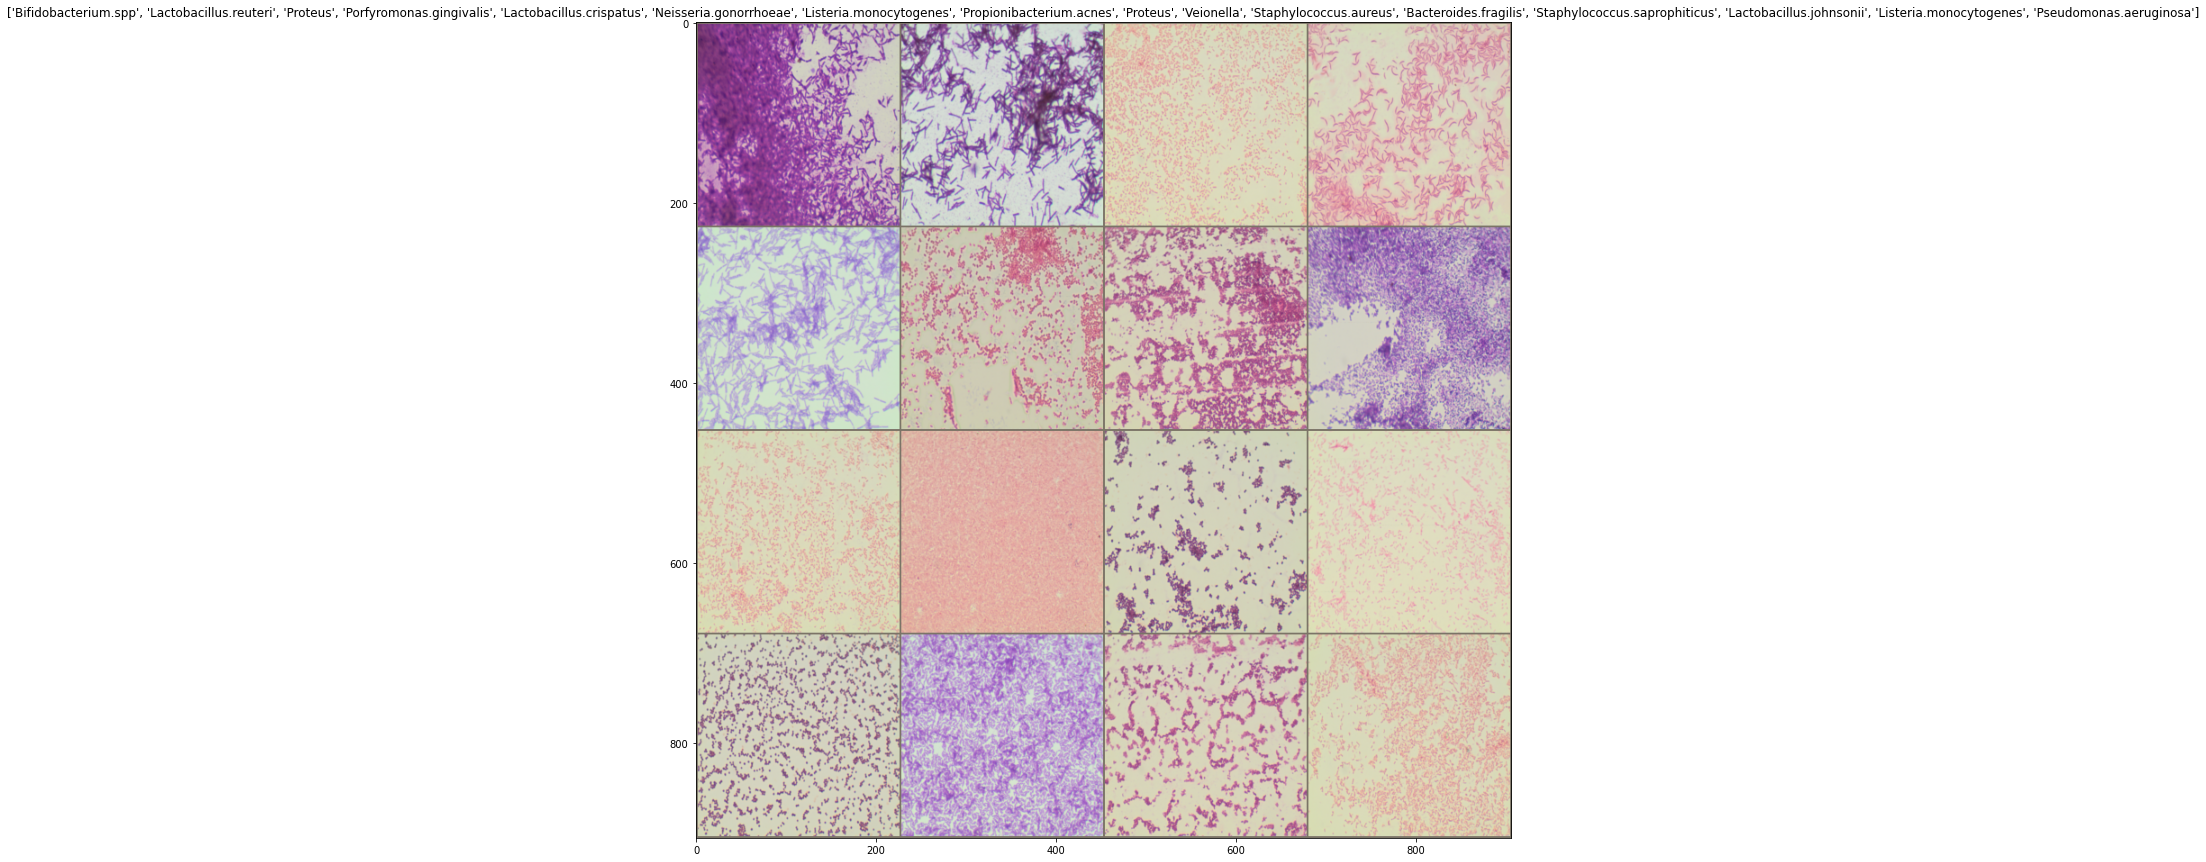

In [14]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [15]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [16]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

model.fc = nn.Linear(2048,33)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [17]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'bacteria.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)

trainer = Trainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.41977983713150024
Epoch : 1 Train Loss : 1.510055 Train Acc : 0.721491
Epoch : 1 Valid Loss : 0.419780 Valid Acc : 0.952035


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.41977983713150024 --> 0.1624373096192992
Epoch : 2 Train Loss : 0.503257 Train Acc : 0.923611
Epoch : 2 Valid Loss : 0.162437 Valid Acc : 0.985465


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.1624373096192992 --> 0.10177217978377674
Epoch : 3 Train Loss : 0.346464 Train Acc : 0.939327
Epoch : 3 Valid Loss : 0.101772 Valid Acc : 0.995640


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.10177217978377674 --> 0.07627811696553646
Epoch : 4 Train Loss : 0.244241 Train Acc : 0.963450
Epoch : 4 Valid Loss : 0.076278 Valid Acc : 0.990149


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.07627811696553646 --> 0.044892164802741864
Epoch : 5 Train Loss : 0.193068 Train Acc : 0.968933
Epoch : 5 Valid Loss : 0.044892 Valid Acc : 0.995640


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.044892164802741864 --> 0.035321238851391296
Epoch : 6 Train Loss : 0.157701 Train Acc : 0.973319
Epoch : 6 Valid Loss : 0.035321 Valid Acc : 0.998547


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.035321238851391296 --> 0.025921195279806852
Epoch : 7 Train Loss : 0.134677 Train Acc : 0.980263
Epoch : 7 Valid Loss : 0.025921 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.025921195279806852 --> 0.02293651677711412
Epoch : 8 Train Loss : 0.123845 Train Acc : 0.980263
Epoch : 8 Valid Loss : 0.022937 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.02293651677711412 --> 0.019490227011184014
Epoch : 9 Train Loss : 0.107699 Train Acc : 0.983187
Epoch : 9 Valid Loss : 0.019490 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.019490227011184014 --> 0.015115330255655356
Epoch : 10 Train Loss : 0.098443 Train Acc : 0.986477
Epoch : 10 Valid Loss : 0.015115 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.015115330255655356 --> 0.011027040035832067
Epoch : 11 Train Loss : 0.085774 Train Acc : 0.987939
Epoch : 11 Valid Loss : 0.011027 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.074493 Train Acc : 0.991228
Epoch : 12 Valid Loss : 0.011986 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.011027040035832067 --> 0.00960955360287064
Epoch : 13 Train Loss : 0.075407 Train Acc : 0.989035
Epoch : 13 Valid Loss : 0.009610 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.00960955360287064 --> 0.006072963333450431
Epoch : 14 Train Loss : 0.059211 Train Acc : 0.993787
Epoch : 14 Valid Loss : 0.006073 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.068904 Train Acc : 0.988670
Epoch : 15 Valid Loss : 0.013958 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.006072963333450431 --> 0.005097210979858023
Epoch : 16 Train Loss : 0.062247 Train Acc : 0.989401
Epoch : 16 Valid Loss : 0.005097 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.047250 Train Acc : 0.994883
Epoch : 17 Valid Loss : 0.006385 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.046126 Train Acc : 0.993421
Epoch : 18 Valid Loss : 0.006943 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.048091 Train Acc : 0.993421
Epoch : 19 Valid Loss : 0.005436 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.005097210979858023 --> 0.003837854027488204
Epoch : 20 Train Loss : 0.047965 Train Acc : 0.992690
Epoch : 20 Valid Loss : 0.003838 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.003837854027488204 --> 0.0033102647014243832
Epoch : 21 Train Loss : 0.036312 Train Acc : 0.995980
Epoch : 21 Valid Loss : 0.003310 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Valid_loss decreased 0.0033102647014243832 --> 0.0022503538300868036
Epoch : 22 Train Loss : 0.039410 Train Acc : 0.995249
Epoch : 22 Valid Loss : 0.002250 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.033582 Train Acc : 0.995249
Epoch : 23 Valid Loss : 0.002579 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.036538 Train Acc : 0.994152
Epoch : 24 Valid Loss : 0.002832 Valid Acc : 1.000000


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.041433 Train Acc : 0.993421
Epoch : 25 Valid Loss : 0.003846 Valid Acc : 1.000000


In [20]:
model.load_state_dict(torch.load('/content/bacteria.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss : 0.0017565329209901393
Test Acc : 1.0


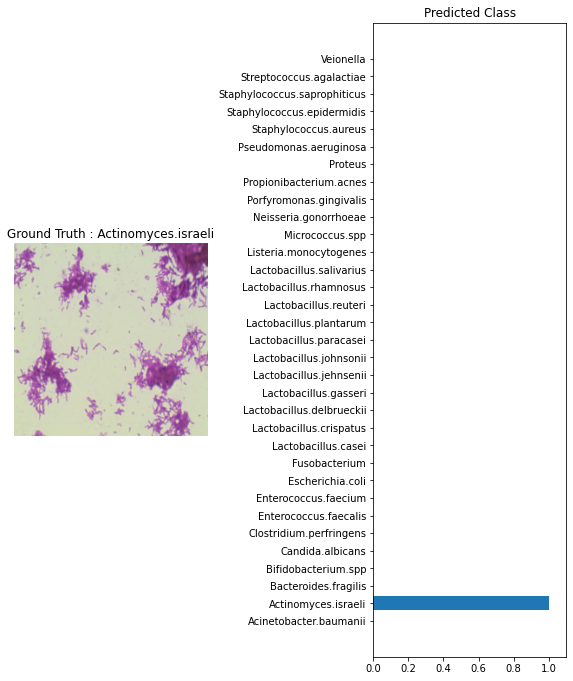

In [34]:
import torch.nn.functional as F

image,label = testset[2]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

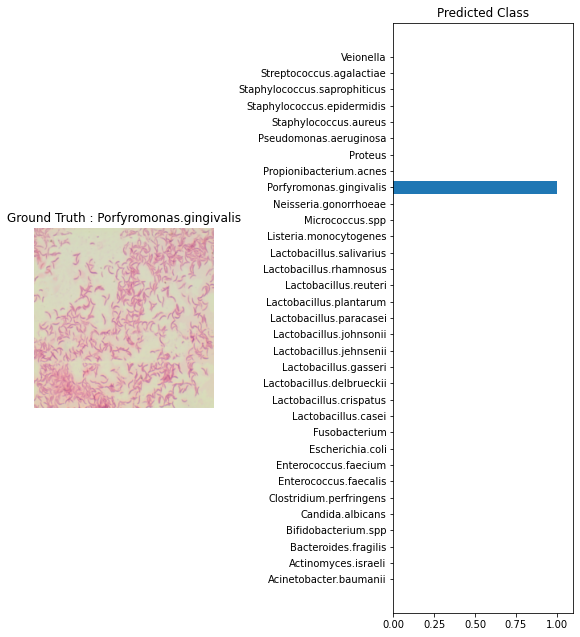

In [35]:

image,label = testset[49]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

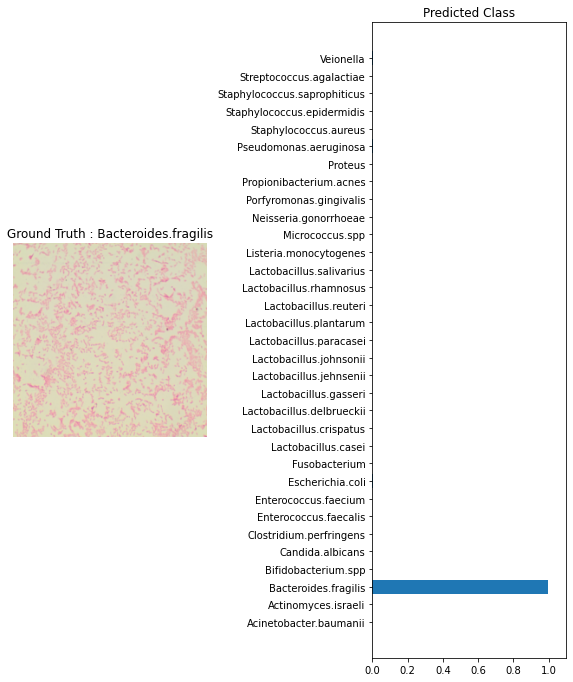

In [36]:

image,label = testset[4]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

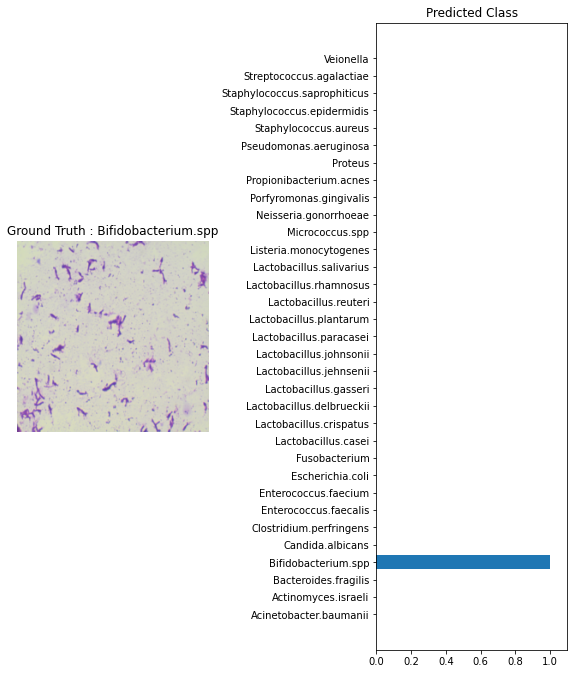

In [37]:

image,label = testset[6]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

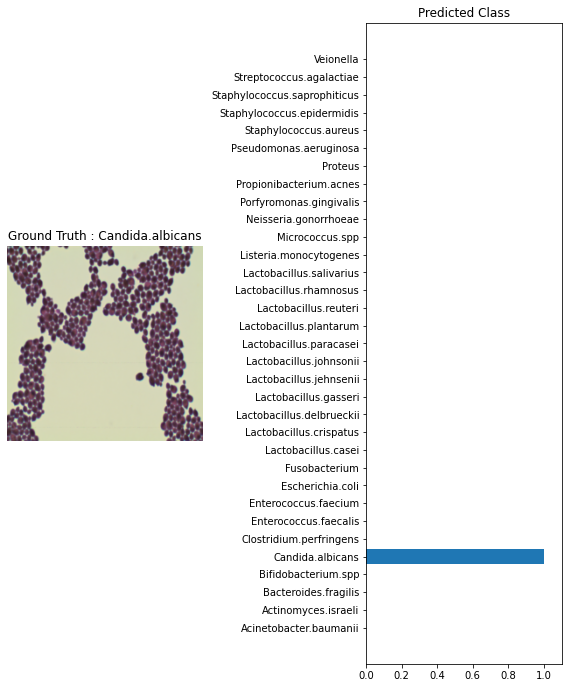

In [38]:

image,label = testset[9]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

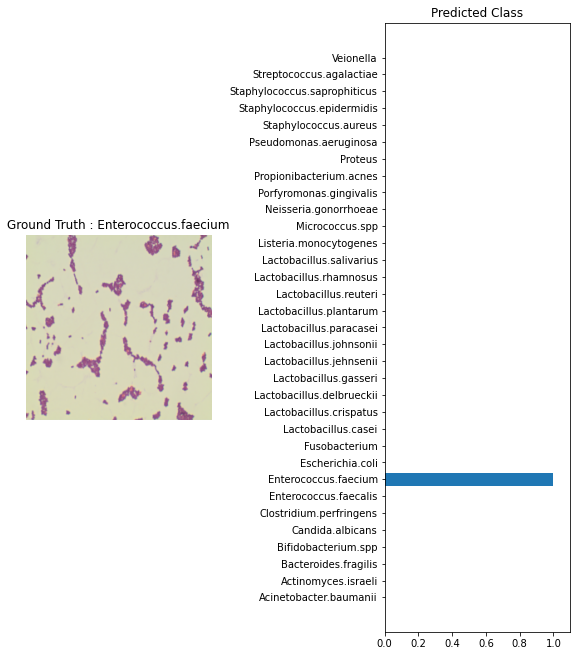

In [39]:

image,label = testset[14]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

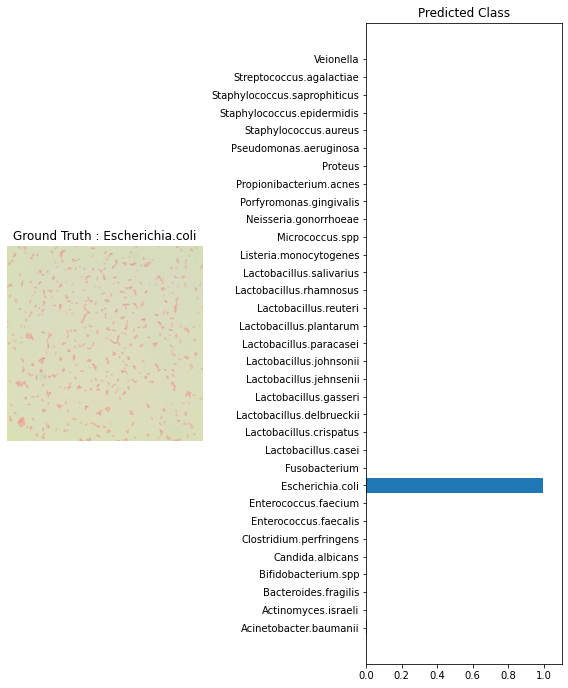

In [40]:

image,label = testset[17]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

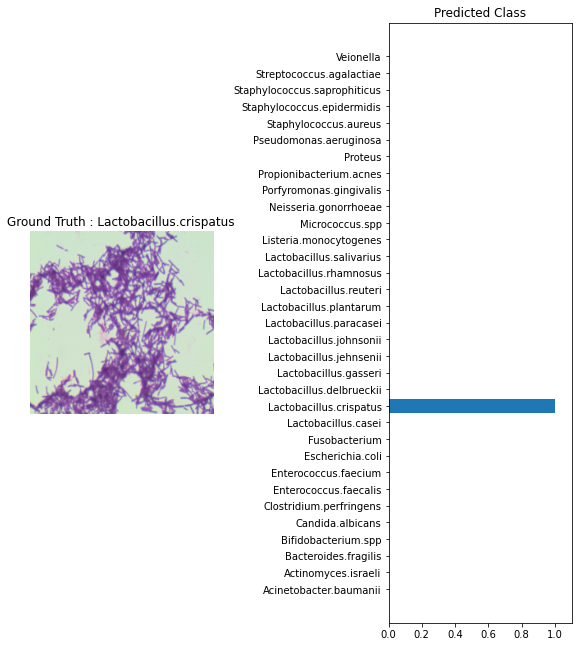

In [41]:

image,label = testset[22]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

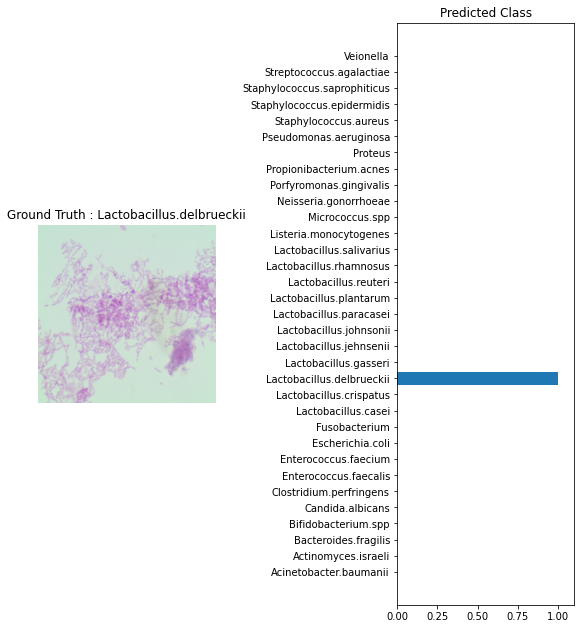

In [42]:

image,label = testset[25]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

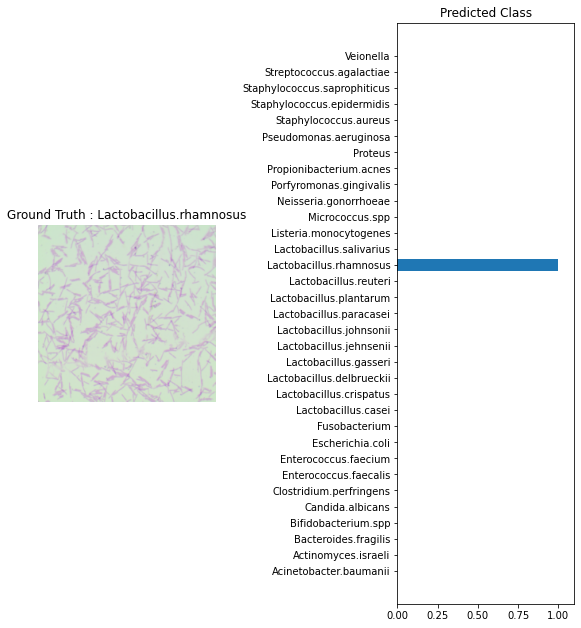

In [43]:

image,label = testset[38]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

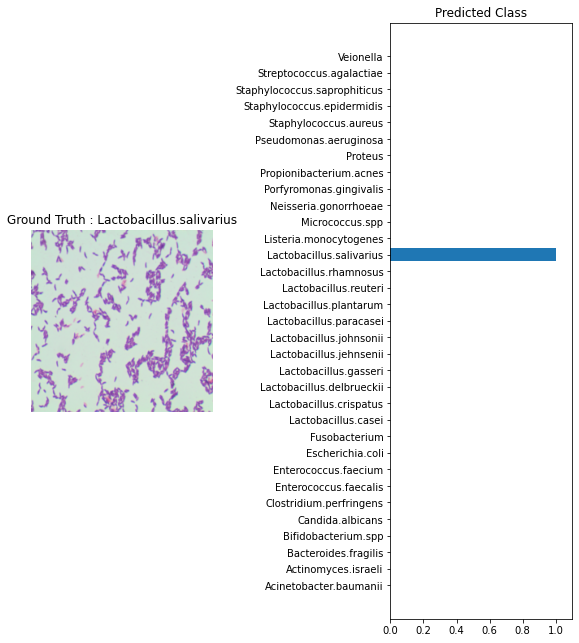

In [45]:

image,label = testset[40]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

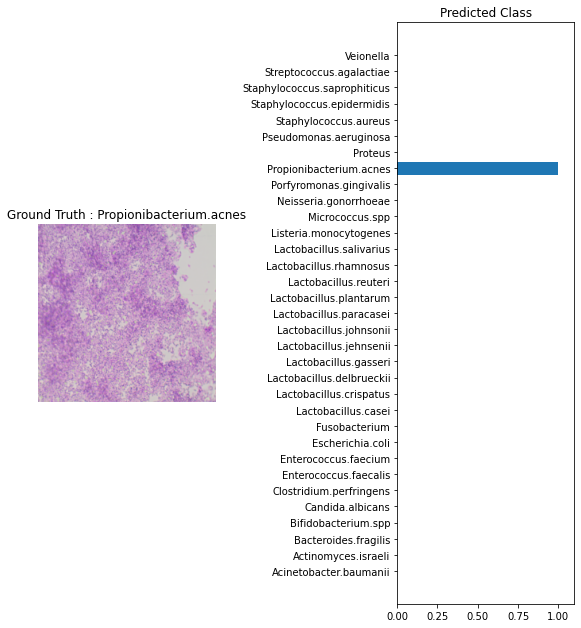

In [46]:

image,label = testset[50]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

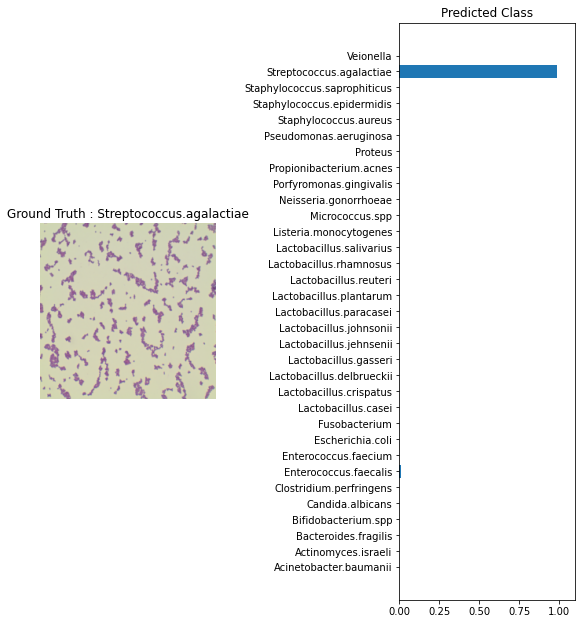

In [47]:

image,label = testset[63]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)